In [1]:
#modeling sky subtraction model vs data points for 5/19/17 night
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
from astropy import units as u

In [2]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

    
def target_1d(subimg,specaps,ds):    
    flux, unc = subimg.extract_spectrum(specaps)
    #plotting 1D extraction of target
    plt.subplot(212)
    plt.step(ds.pixtowl(np.arange(len(flux))), flux)
    plt.title('1D Target Spectrum')
    plt.ylabel('flux -- but ask Erik to be sure (counts/units?)')
    plt.xlabel('wavelength')
    #based below limit choices on info on palomar dblspec webpage
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 1D target spec axis limits for blueside')
        plt.xlim(2800, 7000) #3600,5800 
        plt.ylim(0, plt.ylim()[-1])
    elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 1D target spec axis limits for redside')
        plt.xlim(4700, 11000)
        plt.ylim(0, plt.ylim()[-1])
    return (flux, unc)

#below kinda replaces 'target_1d' above
#defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

# Subtracting Instrument Noise

In [3]:
#Finding all data file for specific target and doing instrumentation noise subtraction
#stating specific files/names to search for later on

flatid = 'DomeFlat'
atlasfiles = fits.open('henear.fits') #use for creating dispersion solution later 
targetID = '79005021831220-Catch22'
all_side_files_target = 'DoubleSpec/20170518/red*.fits'

#determing what instumentation noise is
flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj(flatid,'DoubleSpec/20170518/red*.fits')[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
nfl = reduce_dblspec.create_normalized_flat(flats)   
header = atlasfiles[0].header    
    
#locating all files w/ the target & instrumentation noise subtraction
specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files_target)]
#specs is the inst. noise subtracted group of files with data from target    
    
print("This is lenspecs:",len(specs))

print('specs is the inst. noise subtracted group of files with data from target ')

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


This is lenspecs: 5
specs is the inst. noise subtracted group of files with data from target 


# Creating Dispersion Solution

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


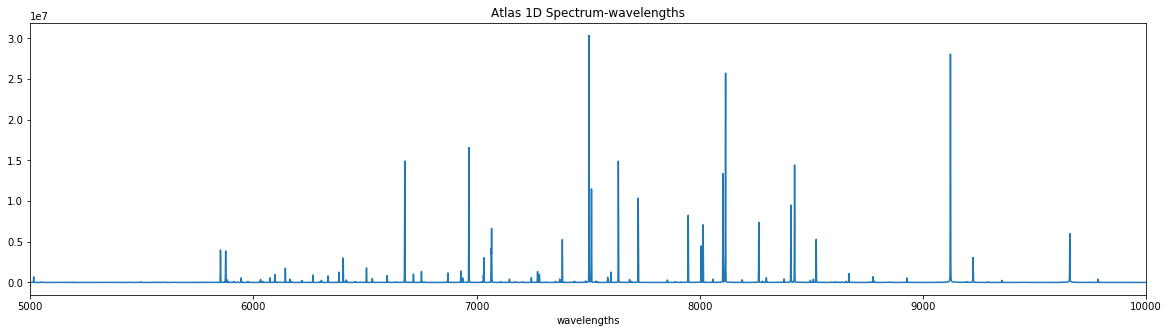

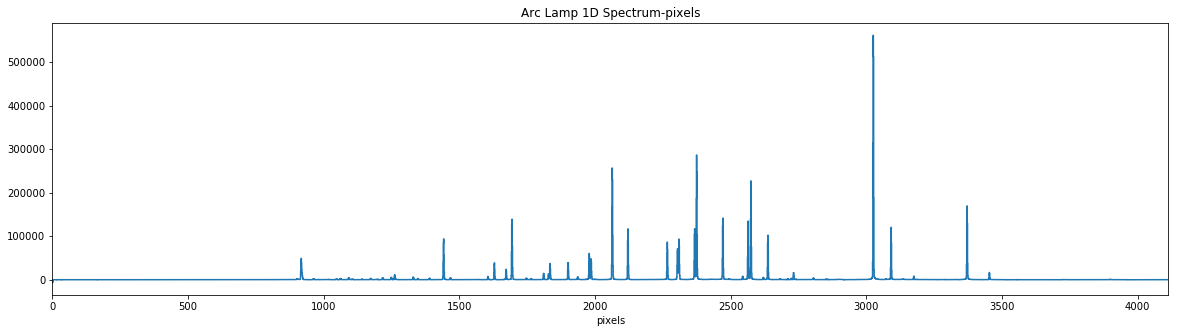

In [4]:
#creating a ds _ part one

#nameing all the datafiles needed
all_side_files_red10 = '20170518/red*.fits' #redside
atlasfiles_red10 = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red10 = '20170518/red0012.fits' #redside
linelist_red10 = reduce_dblspec.HENEAR_LINE_LIST

specset_red10 = pipeline.dispersion(all_side_files_red10, atlasfiles_red10, arcfiles_red10, linelist_red10,flatid)

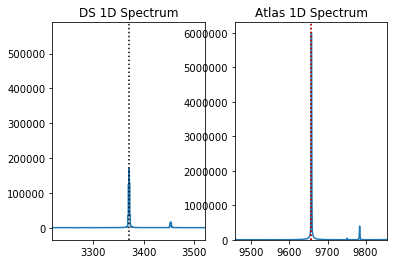

In [5]:
#creating a ds _ part two


#collecting guesses of matching lines from above graphs
#entering (px,wl)guesses & data
pipeline.guess_plot(3370,9657,specset_red10) #outputs (pixel guess, nearest wl/id in linelist)

#collect guesses here ~5 seems good
pixel_guesses_red10 = [3024,2373,2062,1672,3370]
atlas_lines_red10 = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]
guesses_red10 = list(zip(pixel_guesses_red10, atlas_lines_red10)) #making tuples to pass into fcn later

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Failed to find line ArI at wl=7891.075: "Guessed line's peak to base ratio is 1.1153847553894787, which is less than 10"
Failed to find line KrI at wl=7913.4242: "Tried to find peak at 2243.4658680624693 but it's in a valley, not a peak"
Found line ArI at wl=7948.1764
Clipped 0 lines
Failed to find line ArI at wl=8006.1567: "Guessed line's peak to base ratio is 6.71869024521498, which is less than 10"
Failed to find line ArI at wl=8014.7857: "Guessed line's peak to base ratio is 7.395561544387761, which is less than 10"
Failed to find line KrI at wl=8059.5038: "Tried to find peak at 2338.0234170166977 but it's in a valley, not a peak"
Found line ArI at wl=8103.6931
Clipped 0 lines
Found line ArI at wl=8115.311
Clipped 0 lines
Failed to find line KrI at wl=8190.0543: "Guessed line's peak to base ratio is 0.9423511275390428, which is less than 10"
Found line ArI at wl=8264.5225
Clipped 0 lines
Failed to find line KrI at wl=8281.0495: "Guessed line's peak to base ratio is 0.95882587983778

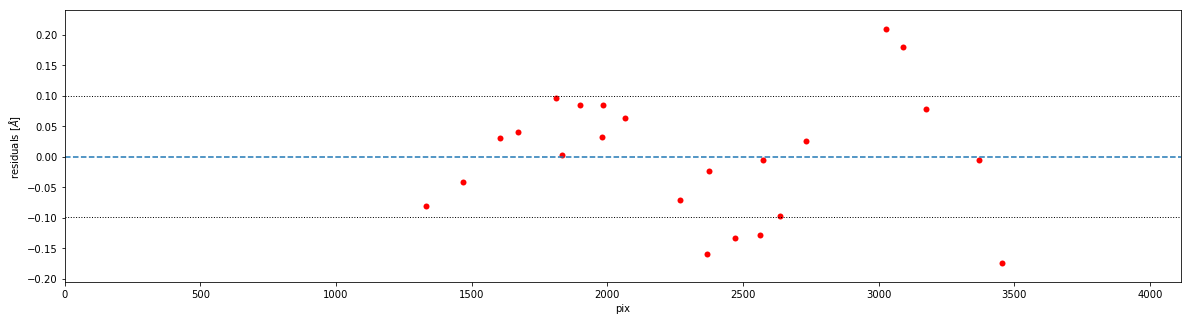

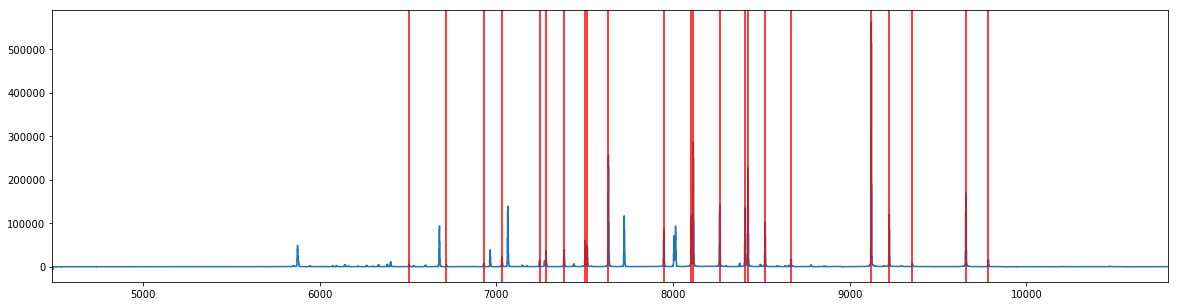

In [6]:
#creating a ds _ part three
ds_red10 = pipeline.goodness_of_matches(arcfiles_red10,guesses_red10,all_side_files_red10,atlasfiles_red10,linelist_red10,flatid);

#this is the final ds to apply to catch22 data for this entire nb

# Sky Subtraction & stacking - data still 2D

In [7]:
#stacking all those instrument-noise-subtracted target data files-help increase s/n 

comb = reduce_dblspec.combine_imgs(specs) #comb-all files data from target stacked
skyaps=[(20,33),(265,320)]#[(55,120),(190,350)] #target 35-260
#skyaps=[(30,110),(180,400)] 
model=('poly',2)

subimg2, comb2, fitmodels = sky_subtract(comb,skyaps,model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

## SANITY CHECK

[ -6.35448395e+01   6.67014764e+01  -8.01993183e+02 ...,  -1.46522451e-01
  -3.74183006e-01  -1.10346141e+00]


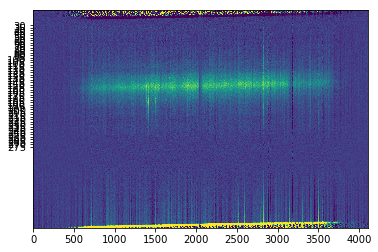

In [8]:
# SANITY CHECK

#first: want to see this newly cleaned 2d data visually
mydata=subimg2.data
vmin=-10
vmax=45
#plt.figure(figsize=(25,20)) ##REMOVE THIS LINES # TO SEE GRAPH USEFULNESS!!!!!!!!!!!!!!!!!!!!!!!!!

#instead of show_image function at top, doing this to estimate spatial row limits of H-alpha emission 
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
plt.yticks(np.arange(30,280,5))
plt.imshow(mydata,aspect='auto',interpolation='nearest',vmin=vmin,vmax=vmax)

#second: now want to see newly cleaned data in numbers
print(subimg2.data[::][0])

# Extracting 2D target spectrum (reducing spatial parameters)

## ASK ERIK
### This 10 pix cut is weird....if I add 35 (target ap) does that include the 10?
### Or does it act like another cut so I should be adding 45???
### Confusing b/c flux_data is len226, same as range of target aperature, 
### so was the 10 ever really cut from flux? or only cut from wl?

FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls), NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!
flux data shape: (226, 4104)
NOTE THIS CELL CUTS OFF FIRST 10 PIXELS OF DATA FROM ENTIRE CCD SIZE DATASET DUE TO OSCILLS  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


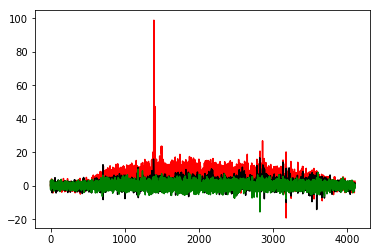

In [9]:
#first need to get 1D spectrum for each spatial pixel row in the 2D target data

#extracting target spec from whole 2d spec
target_aperature=(35,260) #target location

flux_data=[] #empty list to hold target 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #makes list for which rows to extracct spec from
#print (apslc) #as expected, +1 so doesnt cut off last value

#np.shape(subimg2.data)#(440, 4114)
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects a list of every row's spec within the target location
flux_data=np.array(flux_data)   
print("FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls), NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!" )
#need to find a way to sum over diff ranges of apslc 

#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10


plt.plot(flux_data[145],color='r')#near galaxy center
plt.plot(flux_data[45],color='k') #near galaxy edge
plt.plot(flux_data[224],color='g')#near opposite galaxy edge

print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE THIS CELL CUTS OFF FIRST 10 PIXELS OF DATA FROM ENTIRE CCD SIZE DATASET DUE TO OSCILLS ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')

## SANITY CHECK - BAD

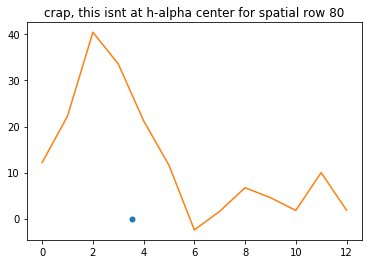

In [10]:
#good
#centroid testing in halpha reduced wl range....no ds applied

#cutting flux array to see wl's around H-alpha
flux_data_short2 = flux_data[:,1387:1400] #still guessing - need convert pix to wl here somehow
#guess will be calculated from target's z estimate of h-alpha wl location---will need to apply ds tho

row = 80 #change which spatial row visualizing here

#doing centroid testing on individual rows to see if centroid = halpha center 
testha = flux_data_short2[row] #specifying one row to test h-alpha centroid
testnewha = testha[np.newaxis,:] #converting 1d array into a 'fake' 2d array for next line
x,y = centroid_com(testnewha) #centroiding fcn requires 2d array input

#plotting results
plt.plot(x,y,'.',markersize=10)
plt.plot(testha);
plt.title('crap, this isnt at h-alpha center for spatial row {:}'.format(row))
#print(np.shape(testnewha)) #confirms made into fake 2d array
#print(testnewha[0])

# Continnum Subtraction for Entire Target

shape new: (226, 4104)
new is the name of continum subtracted (and inst & sky subtracted, spatially reduced) 2d target data array


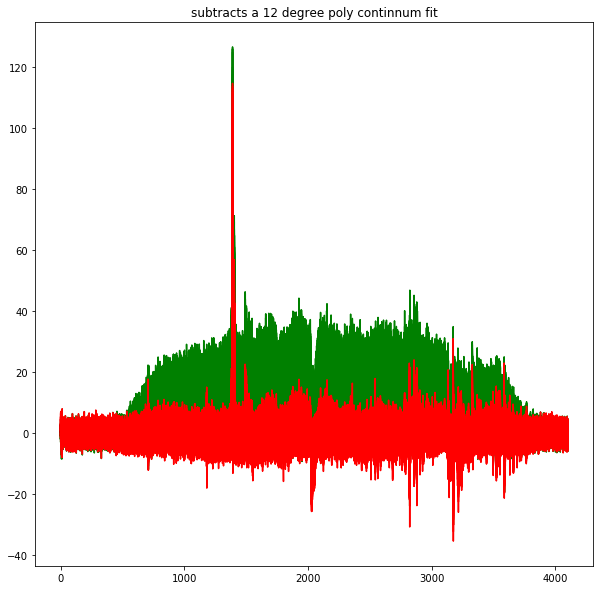

In [11]:
#good
#fitting continum for entire target now

#want to fit continum using a low-order poly (linear even??) for each spatial pix(row)
spatial_indexes = np.arange(0,len(flux_data))
new = []


for row in flux_data: #i isnt indiv data its each spatial row of data
    xpix = np.arange(0,len(row),1) #lists pixels by index
    polydeg = 12 #what degree of line to fit to continnum
    poly = np.poly1d(np.polyfit(xpix,row, polydeg)) #this determines the fit of the continum
    spec_subtracted = row - poly(xpix)
    new.append(spec_subtracted)
new = np.array(new)

divide = 4104
amtofrows = int(len(new)/divide) #also ensured int not float
plt.figure(figsize=(10,10))

print('shape new:',np.shape(new))

plt.plot(flux_data.T, color='g'); #original data
plt.plot(new.T,color='r'); #continum subtracted data
plt.title('subtracts a {:} degree poly continnum fit'.format(polydeg))

print('new is the name of continum subtracted (and inst & sky subtracted, spatially reduced) 2d target data array')


## REPEATED BAD SANITY CHECK- good now

new blue dot 2.41862680072 0.0
old blue dot 3.7462368393 0.0
This seems to work well for rows close to core, but very poor for farther distances - erik says ok b/c expect oscills & irregular dwarfs for a reason 


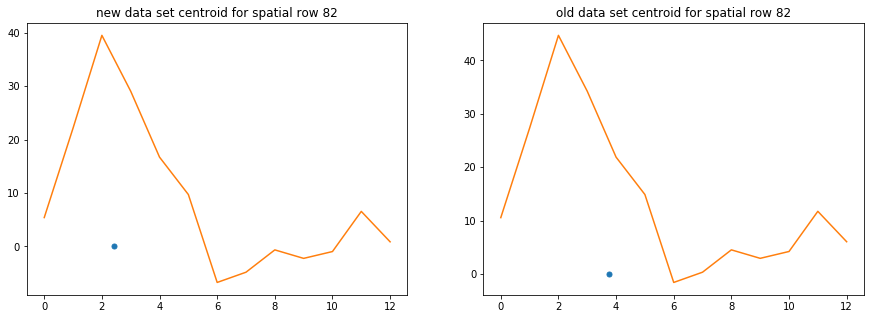

In [12]:
#new data centroiding

new_short = new[:,1387:1400] #still guessing - need convert pix to wl here somehow
#guess will be calculated from target's z estimate of h-alpha wl location---will need to apply ds tho

row = 82 #change spatial row viewing here
#62, 27, 222 bad
#82, 122, 182 good


#new continum subt data
new_testha = new_short[row]
new_testha2 = new_testha[np.newaxis,:]
x2,y2 = centroid_com(new_testha2)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(x2,y2,'.',markersize=10)
ax1.plot(new_testha);
ax1.set_title('new data set centroid for spatial row {:}'.format(row))


#original data from above bad sanity check just replotting for comparison here
testha = flux_data_short2[row] #gets weird near end of range 0-226
testnewha = testha[np.newaxis,:] #converting 1d array into a 'fake' 2d array 
x,y = centroid_com(testnewha) #centroiding fcn requires 2d array input
ax2.plot(x,y,'.',markersize=10)
ax2.plot(testha);
ax2.set_title('old data set centroid for spatial row {:}'.format(row))
print('new blue dot',x2,y2)
print('old blue dot',x,y)
print('This seems to work well for rows close to core, but very poor for farther distances - erik says ok b/c expect oscills & irregular dwarfs for a reason ')

# Getting Galaxy Core to Center Rot. Curve around

## First Making 1D Spectrum

In [13]:
#no time to figure out why this aperture gives errors when doing the uncertaining within the function
side = 'red'
subtracted_2d = flux_data #(226,4104)
aperture = (1,225)
#extract_spectrum(side, subtracted_2d, aperture)

shape (226, 1)
x: 0.0 y: 117.150852463 y is the spatial core location still in pixels & in the Reduced spectral range
to get full plate scale pix value add 35 and 10 from 1D spec cut due to oscillations
GALAXY CORE (based on entire red side plate scale) IS AT SPATIAL PIXEL: 152.150852463
SPACE_PIX_CORRECTION DEFINED HERE!!!!!!!
double check corrections after decide about 10 pix cut around ln[8]


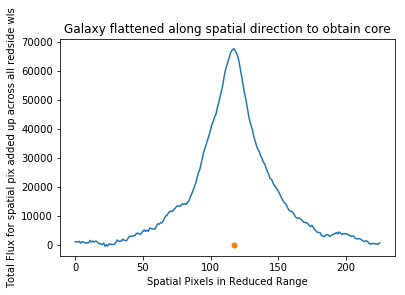

In [14]:
#hack way of doing above without a nice function

#flattening to be along spatial direction (histogram like)
flux_array = np.sum(flux_data,axis=1) #explicitly making an array
flux_array2d = flux_array[:, np.newaxis] #need 2d for centroiding


print('shape',np.shape(flux_array2d))
x_galcore, y_galcore = centroid_com(flux_array2d) #actually doing the centroiding

#plotting
plt.plot(flux_array2d);
plt.plot(y_galcore, x_galcore ,'.',markersize=10)
plt.xlabel('Spatial Pixels in Reduced Range')
plt.ylabel('Total Flux for spatial pix added up across all redside wls')
plt.title('Galaxy flattened along spatial direction to obtain core')

#below is amt of pix to add to target pix value to get matching plate pix #doesnt help total len tho
space_pix_correction = target_aperature[0] #from ln[9] in 1d target extract; maybe need to do this->#10 from pix cut from oscill in 1D
spatial_core_pix = y_galcore + space_pix_correction #(adds 35 to correct from target extraction)

#conclusions
print('x:',x_galcore,'y:',y_galcore, 'y is the spatial core location still in pixels & in the Reduced spectral range')
print('to get full plate scale pix value add {:} and 10 from 1D spec cut due to oscillations'.format(target_aperature[0]))
print('GALAXY CORE (based on entire red side plate scale) IS AT SPATIAL PIXEL:',spatial_core_pix)
print('SPACE_PIX_CORRECTION DEFINED HERE!!!!!!!')
print('double check corrections after decide about 10 pix cut around ln[8]')

# Applying DS -- getting pix to wl associations [Converting Pixels --> kpc] 

In [15]:
#good
#applying ds to get wl-pix associations

#first use original data to get correct wl/pix ranges to correct for cuts above
print('verifying ccd plate/original data len',len(subimg2.data[::][0])) #original 2D data


#applying DS

#wl to pix association
wl = np.array(ds_red10.pixtowl(np.arange(len(subimg2.data[::][0]))))

#pix to wl association
px = []
for i in wl:
    i = int(i)
    pix = ds_red10.wltopix(i)
    px.append(pix)
px = np.array(px)


#checking ds gave 1-1 px-wl associations
print('wl:',wl)
print('px:',px)
print('px len:',len(px))
print('wl len:',len(wl))

#make this a table to carry around associations
index = np.arange(0,len(wl))
dst = Table([index, wl, px], names=('index', 'wl', 'px'))
dst #table of conversions between wl & pix plus an index to call indiv rows from table easily

verifying ccd plate/original data len 4114
wl: [  4488.43143529   4489.93082177   4491.43024058 ...,  10800.94217958
  10802.48352352  10804.02485553]
px: [ -2.87745211e-01   3.79200774e-01   1.71306397e+00 ...,   4.11038873e+03
   4.11168630e+03   4.11298387e+03]
px len: 4114
wl len: 4114


index,wl,px
int64,float64,float64
0,4488.43143529,-0.287745211148
1,4489.93082177,0.379200773968
2,4491.43024058,1.71306397431
3,4492.9296917,2.37998119461
4,4494.42917511,3.71378688821
5,4495.92869082,4.38067536659
6,4497.42823881,5.7144235992
7,4498.92781907,6.38128335852
8,4500.42743158,7.71497417587


In [16]:
#Do THIS AFTER CENTROIDING!!!

#do the pixel plate scale too!!!!!!!!!!!!!!!!!!!!!!!!!

r_in_arcmin = 1*u.arcmin# radial distance from centre of object in arcmin
distance = 5*u.Mpc # distance of object from us
r_in_kpc = (r_in_arcmin/u.rad*distance).to("kpc") # radial distance from centre of object in kpc

redplatescale = 0.293*u.arcsec/u.pixel
blueplatescale = 0.389*u.arcsec/u.pixel

dbsp_pix_equiv = u.pixel_scale(redplatescale)
r_in_pixel = 2*u.pixel
r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)

r_in_arcmin

<Quantity 0.009766666666666667 arcmin>

# H-alpha Centroids for Entire Target

len 226 <class 'numpy.ndarray'> (226,)
len 226 <class 'numpy.ndarray'> (226,)
double check corrections after decide how to deal with 10 pix cut from around ln[8]


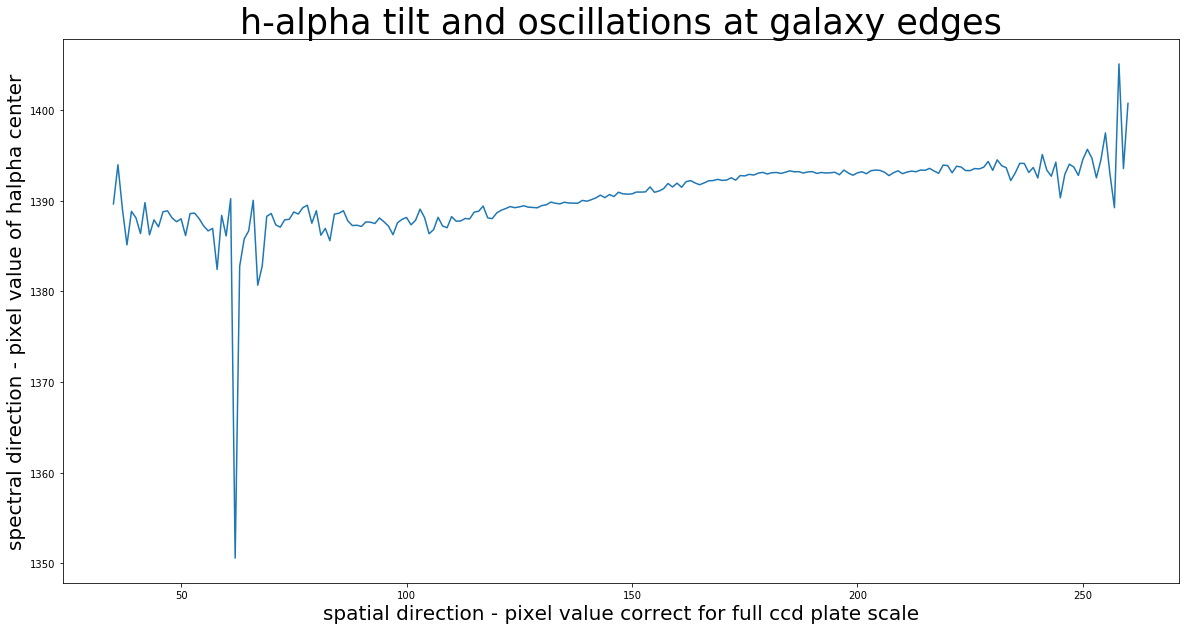

In [17]:
#good
#gets h-alpha centroid values for every spatial row within the target range 

#below for reference, uses full ccd wl range - first defined when applied DS
#wl = np.array(ds_red10.pixtowl(np.arange(len(subimg2.data[::][0]))))
wl_shorter2 = wl[1387:1400] #isolate wl around h-alpha using full ccd plate wl range



mylist2 = []
mylist_ys2 = []
holding2 = []
ha_wls2 = []
#below for reference- new is continuum subst target flux data (flux_data has 10 wl cut)
#concerned 10 wl cut means 10 flux cut too in the lenght of the data but cant decide
#if the 10 is already accounted for by +1387 or should also add into space_pix_correction2
#b/c that 10 cut cutout those wl's and corresponding fluxes
#new_short = new[:,1387:1400] #cut to isolate wl around h-alpha


for row in new_short:
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    #print('row?',flux_fake2d)
    mylist4, mylist5 = centroid_com(flux_fake2d2)#finds center(x,y) of halpha for each row array
    #print(mylist4,mylist5)
    holding_arr2 = row, wl_shorter2
    x = np.array([row,wl_shorter2])
    mylist_ys2.append(mylist5)
    mylist2.append(mylist4) #collects all halpha centers per row
mylist2=np.array(mylist2)

#correction for target wl pix's to match index of full ccd plate pix's (still not correct len but dont care about below target pixs-no data there neway)
wl_pix_correction2 = mylist2 + 1387 #decide how to better automate/track this

#dont have to account for osciallations b/c used full ccd plate range b4 wl cut 4 h-alpha isolation
space_pix_correction2 = np.arange(len(mylist2)) + space_pix_correction

print('len',len(mylist2),type(mylist2), np.shape(mylist2))
print('len',len(space_pix_correction2),type(space_pix_correction2), np.shape(space_pix_correction2))


print('double check corrections after decide how to deal with 10 pix cut from around ln[8]')
    
#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of halpha center',fontsize=20)
plt.plot(space_pix_correction2,wl_pix_correction2)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('h-alpha tilt and oscillations at galaxy edges',fontsize=35)
#plt.ylim(-1,10)

# Converting Pixels --> kpc 

## ASK if core centering subtraction done on distance axis or velocity axis


In [18]:
#centering  around core......chose on distance axis for now

#below for reference
#wl_pix_correction2 is pix of ha centroid in full plate scale
#space_pix_correction2 is row pix of each centroid
#spatial_core_pix is pixel value of the galaxy core in full plate scale


location_pix = space_pix_correction2 - spatial_core_pix

#print('space',space_pix_correction2)
#print('location', location_pix)

In [19]:
#maybe delete
''' 
arcmins = []

for i in space_pix_correction2:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    dbsp_pix_equiv = u.pixel_scale(redplatescale)
    r_in_pixel = i*u.pixel
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)
    #print(type(r_in_arcmin)) #astropy.units.quantity.Quantity
    #r_in_arcmin.append(arcmins)
    #arcmins.append(r_in_arcmin)
#armins = np.array(arcmins)
#print(arcmins)
'''

" \narcmins = []\n\nfor i in space_pix_correction2:\n    r_in_arcmin = 1*u.arcmin\n    redplatescale = 0.293*u.arcsec/u.pixel\n    dbsp_pix_equiv = u.pixel_scale(redplatescale)\n    r_in_pixel = i*u.pixel\n    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)\n    #print(type(r_in_arcmin)) #astropy.units.quantity.Quantity\n    #r_in_arcmin.append(arcmins)\n    #arcmins.append(r_in_arcmin)\n#armins = np.array(arcmins)\n#print(arcmins)\n"

In [20]:
#maybe delete
''' 
distance = 37*u.Mpc # distance of object from us
another =[]
for i in armins:
    r_in_kpc = (i/u.rad*distance).to("kpc")
    another.append(r_in_kpc)
another = np.array(another)
another'''

' \ndistance = 37*u.Mpc # distance of object from us\nanother =[]\nfor i in armins:\n    r_in_kpc = (i/u.rad*distance).to("kpc")\n    another.append(r_in_kpc)\nanother = np.array(another)\nanother'

In [21]:
arcmins = []
another =[]
more = []

for i in location_pix:#space_pix_correction2:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    dbsp_pix_equiv = u.pixel_scale(redplatescale)
    r_in_pixel = i*u.pixel
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)
    #print(type(r_in_arcmin))
    distance = 37*u.Mpc # distance of object from us
    r_in_kpc = (r_in_arcmin/u.rad*distance).to("kpc")
    #print(r_in_kpc) #WTF THESE ARE HUGE!!! 73Kpc?!?!?!?!?
    ##more = [r_in_kpc]
    more = r_in_kpc
    another.append(more)
#another = np.array(another)
another

    

[<Quantity -6.157290788788212 kpc>,
 <Quantity -6.104732137619127 kpc>,
 <Quantity -6.052173486450042 kpc>,
 <Quantity -5.999614835280957 kpc>,
 <Quantity -5.947056184111872 kpc>,
 <Quantity -5.894497532942786 kpc>,
 <Quantity -5.841938881773702 kpc>,
 <Quantity -5.7893802306046185 kpc>,
 <Quantity -5.736821579435533 kpc>,
 <Quantity -5.684262928266448 kpc>,
 <Quantity -5.631704277097363 kpc>,
 <Quantity -5.579145625928278 kpc>,
 <Quantity -5.526586974759193 kpc>,
 <Quantity -5.47402832359011 kpc>,
 <Quantity -5.421469672421025 kpc>,
 <Quantity -5.3689110212519395 kpc>,
 <Quantity -5.316352370082854 kpc>,
 <Quantity -5.26379371891377 kpc>,
 <Quantity -5.211235067744684 kpc>,
 <Quantity -5.1586764165756 kpc>,
 <Quantity -5.106117765406516 kpc>,
 <Quantity -5.053559114237431 kpc>,
 <Quantity -5.001000463068346 kpc>,
 <Quantity -4.948441811899261 kpc>,
 <Quantity -4.895883160730176 kpc>,
 <Quantity -4.843324509561091 kpc>,
 <Quantity -4.790765858392006 kpc>,
 <Quantity -4.738207207222922 

(1385, 1400)

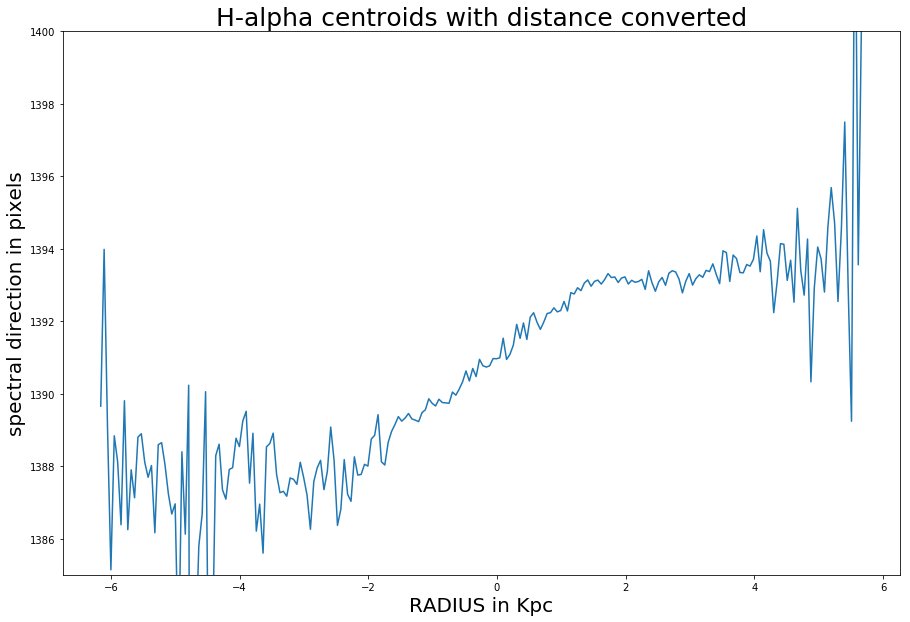

In [24]:
from astropy.visualization import quantity_support
quantity_support() 

from matplotlib import pyplot as plt
plt.figure(figsize=(5,3))

plt.figure(figsize=(15,10))
plt.plot(another * u.kpc,wl_pix_correction2)
plt.title('H-alpha centroids with distance converted',fontsize=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)


plt.ylim(1385,1400)

# Converting wl to velocity

In [23]:
#below for reference
#wl_pix_correction2 is pix of ha centroid in full plate scale

